In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tensorflow as tf
from scipy import stats # for mode calculation
import seaborn as sns
from AdversarialExamples import AdversarialExamples

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=10)

class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

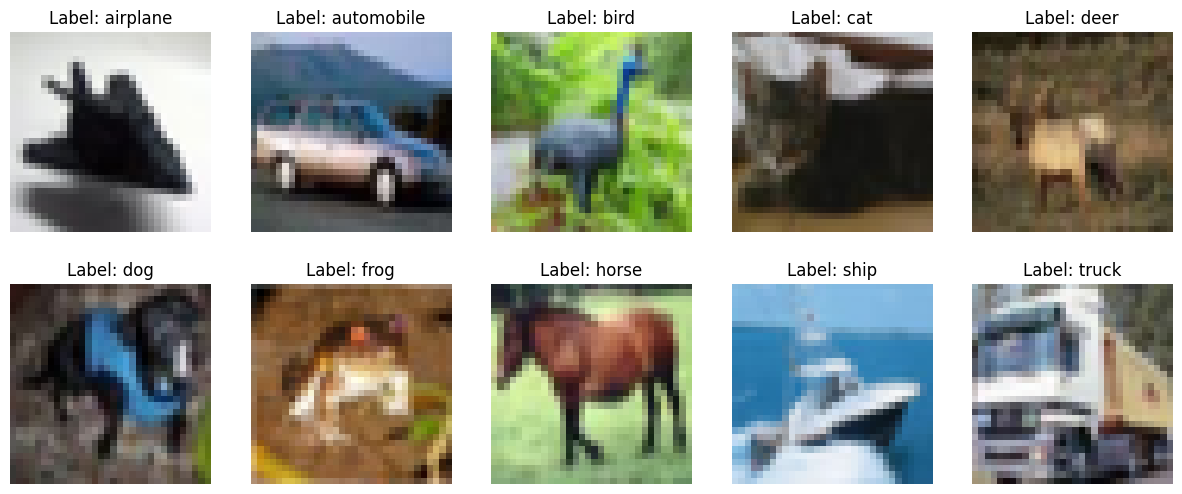

In [4]:
fig = plt.figure(0)
fig.set_size_inches(15, 6)
for j in range(10):
    for i in range(100):
        if y_train[i][0] == j:
            fig.add_subplot(2, 5, j+1)
            plt.imshow(x_train[i])
            plt.axis('off')
            plt.title("Label: {}".format(class_names[j]))
            break

In [3]:
# y is one-hot
def get_gradient_norms(model, x, y):
    x = tf.convert_to_tensor(x, dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(x)
        predictions = model(x)
        loss = tf.keras.losses.categorical_crossentropy(y, predictions)
    
    gradients = tape.gradient(loss, x)
    gradients = tf.reshape(gradients, (gradients.shape[0], gradients.shape[1] * gradients.shape[2] * gradients.shape[3]))
    gradient_norms = tf.norm(gradients, ord='euclidean', axis=1)

    return gradient_norms


In [4]:
# y is one-hot
def get_correct_predictions_mask(model, x, y):
    predictions = tf.argmax(model(x), axis=1)
    y = tf.argmax(y, axis=1)
    correct_predictions = predictions == y
    return correct_predictions

# Adversarial Training

In [5]:
original_model = AdversarialExamples.get_model()
original_model.load_weights("final/final.weights.h5")

adv_training_model = AdversarialExamples.get_model()
adv_training_model.load_weights("adversarial_learning/random_adversary_model.weights.h5")

dynamic_adv_training_model = AdversarialExamples.get_model()
dynamic_adv_training_model.load_weights("adversarial_learning/dynamic_fgsm_adversarial_training_model.weights.h5")

C:\Users\ari15\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ari15\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


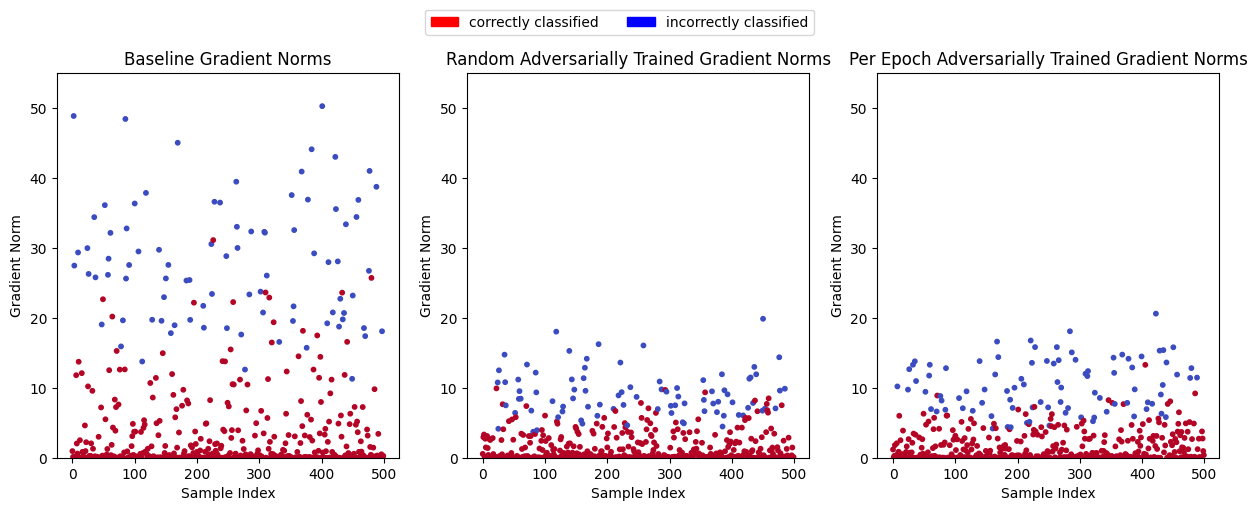

In [28]:
n = 500

original_gradient_norms = get_gradient_norms(original_model, x_test[:n], y_test_one_hot[:n])
original_correct_predictions_mask = get_correct_predictions_mask(original_model, x_test[:n], y_test_one_hot[:n])

adv_training_gradient_norms = get_gradient_norms(adv_training_model, x_test[:n], y_test_one_hot[:n])
adv_training_correct_predictions_mask = get_correct_predictions_mask(adv_training_model, x_test[:n], y_test_one_hot[:n])

dynamic_adv_training_gradient_norms = get_gradient_norms(dynamic_adv_training_model, x_test[:n], y_test_one_hot[:n])
dynamic_adv_training_predictions_mask = get_correct_predictions_mask(dynamic_adv_training_model, x_test[:n], y_test_one_hot[:n])


# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Plot each scatter plot in its respective subplot
axes[0].scatter(range(n), original_gradient_norms, c=original_correct_predictions_mask, cmap="coolwarm", s=10)
axes[0].set_title("Baseline Gradient Norms")
axes[0].set_xlabel("Sample Index")
axes[0].set_ylabel("Gradient Norm")
axes[0].set_ylim(0, 55)

axes[1].scatter(range(n), adv_training_gradient_norms, c=adv_training_correct_predictions_mask, cmap="coolwarm", s=10)
axes[1].set_title("Random Adversarially Trained Gradient Norms")
axes[1].set_xlabel("Sample Index")
axes[1].set_ylabel("Gradient Norm")
axes[1].set_ylim(0, 55)

axes[2].scatter(range(n), dynamic_adv_training_gradient_norms, c=dynamic_adv_training_predictions_mask, cmap="coolwarm", s=10)
axes[2].set_title("Per Epoch Adversarially Trained Gradient Norms")
axes[2].set_xlabel("Sample Index")
axes[2].set_ylabel("Gradient Norm")
axes[2].set_ylim(0, 55)

red_correct = mpatches.Patch(color='red', label='correctly classified')
blue_incorrect = mpatches.Patch(color='blue', label='incorrectly classified')
fig.legend(
    handles=[red_correct, blue_incorrect],
    loc='upper center',  # Place the legend at the top-center
    bbox_to_anchor=(0.5, 1.02),  # Adjust the position
    ncol=2  # Spread the legend items across two columns
)

plt.show()


Accuracy of 3 models on un perturbed dataset

In [61]:
loss, accuracy = original_model.evaluate(x_test[:n], y_test_one_hot[:n], verbose=0)
print(f"original_model - loss: {loss}, accuracy: {accuracy}")

loss, accuracy = adv_training_model.evaluate(x_test[:n], y_test_one_hot[:n], verbose=0)
print(f"adv_training_model - loss: {loss}, accuracy: {accuracy}")

loss, accuracy = dynamic_adv_training_model.evaluate(x_test[:n], y_test_one_hot[:n], verbose=0)
print(f"dynamic_adv_training_model - loss: {loss}, accuracy: {accuracy}")


original_model - loss: 0.4885174036026001, accuracy: 0.828000009059906
adv_training_model - loss: 0.48575183749198914, accuracy: 0.8299999833106995
dynamic_adv_training_model - loss: 0.5047251582145691, accuracy: 0.8180000185966492


Accuracy of 3 models on fgsm dataset

In [62]:
x_adv_test = AdversarialExamples.create_fgsm_dataset(original_model, x_test[:n], y_test_one_hot[:n], eps=0.01)
loss, accuracy = original_model.evaluate(x_adv_test, y_test_one_hot[:n], verbose=0)
print(f"original_model - loss: {loss}, accuracy: {accuracy}")

x_adv_test = AdversarialExamples.create_fgsm_dataset(adv_training_model, x_test[:n], y_test_one_hot[:n], eps=0.01)
loss, accuracy = adv_training_model.evaluate(x_adv_test, y_test_one_hot[:n], verbose=0)
print(f"adv_training_model - loss: {loss}, accuracy: {accuracy}")

x_adv_test = AdversarialExamples.create_fgsm_dataset(dynamic_adv_training_model, x_test[:n], y_test_one_hot[:n], eps=0.01)
loss, accuracy = dynamic_adv_training_model.evaluate(x_adv_test, y_test_one_hot[:n], verbose=0)
print(f"dynamic_adv_training_model - loss: {loss}, accuracy: {accuracy}")

original_model - loss: 4.455660343170166, accuracy: 0.20399999618530273
adv_training_model - loss: 1.8874391317367554, accuracy: 0.44600000977516174
dynamic_adv_training_model - loss: 2.159510850906372, accuracy: 0.3880000114440918


# Defensive Distillation

In [15]:
teacher_model = AdversarialExamples.get_distillation_model(temperature=50)
teacher_model.load_weights("defensive_distillation/attempt 1/first_distillation_model.weights.h5")

student_model = AdversarialExamples.get_distillation_model(temperature=50)
student_model.load_weights("defensive_distillation/attempt 1/second_distillation_model.weights.h5")

low_temp_student_model = AdversarialExamples.get_distillation_model(temperature=1)
low_temp_student_model.load_weights("defensive_distillation/attempt 1/second_distillation_model.weights.h5")

C:\Users\ari15\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


C:\Users\ari15\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


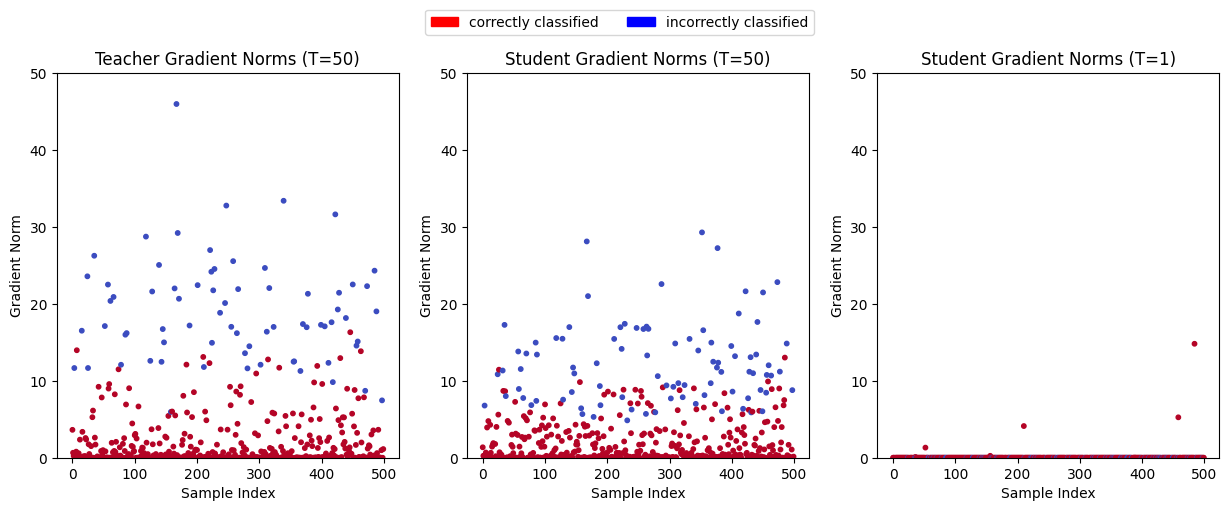

In [27]:
n = 500

teacher_gradient_norms = get_gradient_norms(teacher_model, x_test[:n], y_test_one_hot[:n])
teacher_correct_predictions_mask = get_correct_predictions_mask(teacher_model, x_test[:n], y_test_one_hot[:n])

student_gradient_norms = get_gradient_norms(student_model, x_test[:n], y_test_one_hot[:n])
student_correct_predictions_mask = get_correct_predictions_mask(student_model, x_test[:n], y_test_one_hot[:n])

low_temp_student_gradient_norms = get_gradient_norms(low_temp_student_model, x_test[:n], y_test_one_hot[:n])


# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Plot each scatter plot in its respective subplot
axes[0].scatter(range(n), teacher_gradient_norms, c=teacher_correct_predictions_mask, cmap="coolwarm", s=10)
axes[0].set_title("Teacher Gradient Norms (T=50)")
axes[0].set_xlabel("Sample Index")
axes[0].set_ylabel("Gradient Norm")
axes[0].set_ylim(0, 50)

axes[1].scatter(range(n), student_gradient_norms, c=student_correct_predictions_mask, cmap="coolwarm", s=10)
axes[1].set_title("Student Gradient Norms (T=50)")
axes[1].set_xlabel("Sample Index")
axes[1].set_ylabel("Gradient Norm")
axes[1].set_ylim(0, 50)

axes[2].scatter(range(n), low_temp_student_gradient_norms, c=student_correct_predictions_mask, cmap="coolwarm", s=10)
axes[2].set_title("Student Gradient Norms (T=1)")
axes[2].set_xlabel("Sample Index")
axes[2].set_ylabel("Gradient Norm")
axes[2].set_ylim(0, 50)

# Adjust layout for better spacing
# plt.tight_layout()

red_correct = mpatches.Patch(color='red', label='correctly classified')
blue_incorrect = mpatches.Patch(color='blue', label='incorrectly classified')
fig.legend(
    handles=[red_correct, blue_incorrect],
    loc='upper center',  # Place the legend at the top-center
    bbox_to_anchor=(0.5, 1.02),  # Adjust the position
    ncol=2  # Spread the legend items across two columns
)

# Show the plots
plt.show()

In [7]:
def test_adversarial_dataset(model, x, y, y_one_hot, eps, n, model_name):
        x_adv_test = AdversarialExamples.create_fgsm_dataset(model, x[:n], y_one_hot[:n], eps=eps)
        loss, accuracy = model.evaluate(x_adv_test, y_one_hot[:n], verbose=1)
        print(f"loss: {loss}, accuracy: {accuracy}")

        predictions = tf.argmax(model(x_adv_test), axis=1)
        conf_mat = tf.math.confusion_matrix(y[:n], predictions)

        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_mat.numpy(), annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title(f"{model_name} Confusion Matrix")
        plt.show()

Performance on regular dataset

In [11]:
# teacher (T=50)
loss, accuracy = teacher_model.evaluate(x_test[:n], y_test_one_hot[:n], verbose=0)
print(f"teacher_model - loss: {loss}, accuracy: {accuracy}")

# student (T=50)
loss, accuracy = student_model.evaluate(x_test[:n], y_test_one_hot[:n], verbose=0)
print(f"student_model - loss: {loss}, accuracy: {accuracy}")

# student (T=1)
loss, accuracy = low_temp_student_model.evaluate(x_test[:n], y_test_one_hot[:n], verbose=0)
print(f"low_temp_student_model - loss: {loss}, accuracy: {accuracy}")

teacher_model - loss: 0.39682379364967346, accuracy: 0.8579999804496765
student_model - loss: 0.5140328407287598, accuracy: 0.8199999928474426
low_temp_student_model - loss: 14.282928466796875, accuracy: 0.8199999928474426


Performance on perturbed dataset

In [12]:
x_adv_test = AdversarialExamples.create_fgsm_dataset(teacher_model, x_test[:n], y_test_one_hot[:n], eps=0.01)
loss, accuracy = teacher_model.evaluate(x_adv_test, y_test_one_hot[:n], verbose=0)
print(f"teacher_model - loss: {loss}, accuracy: {accuracy}")

x_adv_test = AdversarialExamples.create_fgsm_dataset(student_model, x_test[:n], y_test_one_hot[:n], eps=0.01)
loss, accuracy = student_model.evaluate(x_adv_test, y_test_one_hot[:n], verbose=0)
print(f"student_model - loss: {loss}, accuracy: {accuracy}")

x_adv_test = AdversarialExamples.create_fgsm_dataset(low_temp_student_model, x_test[:n], y_test_one_hot[:n], eps=0.01)
loss, accuracy = low_temp_student_model.evaluate(x_adv_test, y_test_one_hot[:n], verbose=0)
print(f"low_temp_student_model - loss: {loss}, accuracy: {accuracy}")

teacher_model - loss: 2.746453046798706, accuracy: 0.37400001287460327
student_model - loss: 2.4277689456939697, accuracy: 0.37599998712539673
low_temp_student_model - loss: 25.80278968811035, accuracy: 0.7979999780654907


In [13]:
# fgsm on teacher
x_adv_test = AdversarialExamples.create_fgsm_dataset(teacher_model, x_test[:n], y_test_one_hot[:n], eps=0.01)
loss, accuracy = teacher_model.evaluate(x_adv_test, y_test_one_hot[:n], verbose=0)
print(f"teacher_model - loss: {loss}, accuracy: {accuracy}")

# get fgsm from student t=50, apply to t=1
x_adv_test = AdversarialExamples.create_fgsm_dataset(student_model, x_test[:n], y_test_one_hot[:n], eps=0.01)
loss, accuracy = low_temp_student_model.evaluate(x_adv_test, y_test_one_hot[:n], verbose=0)
print(f"low_temp_student_model (fgsm from student_model)- loss: {loss}, accuracy: {accuracy}")

# get fgsm from student t=1 to student t=1
x_adv_test = AdversarialExamples.create_fgsm_dataset(low_temp_student_model, x_test[:n], y_test_one_hot[:n], eps=0.01)
loss, accuracy = low_temp_student_model.evaluate(x_adv_test, y_test_one_hot[:n], verbose=0)
print(f"low_temp_student_model - loss: {loss}, accuracy: {accuracy}")

# test student model
# n = 500
# test_adversarial_dataset(student_model, x_test, y_test, y_test_one_hot, 0.00, n, "student model")

teacher_model - loss: 2.746453046798706, accuracy: 0.37400001287460327
low_temp_student_model (fgsm from student_model)- loss: 105.4029769897461, accuracy: 0.37599998712539673
low_temp_student_model - loss: 25.80278968811035, accuracy: 0.7979999780654907


Defensive Distillation with softer labels

In [20]:
softer_teacher_model = AdversarialExamples.get_distillation_model(temperature=1)
softer_teacher_model.load_weights("defensive_distillation\Attempt2SofterLabels/first_distillation_model.weights.h5")

softer_student_model = AdversarialExamples.get_distillation_model(temperature=4)
softer_student_model.load_weights("defensive_distillation\Attempt2SofterLabels/second_distillation_model.weights.h5")

softer_low_temp_student_model = AdversarialExamples.get_distillation_model(temperature=0.01)
softer_low_temp_student_model.load_weights("defensive_distillation\Attempt2SofterLabels/second_distillation_model.weights.h5")

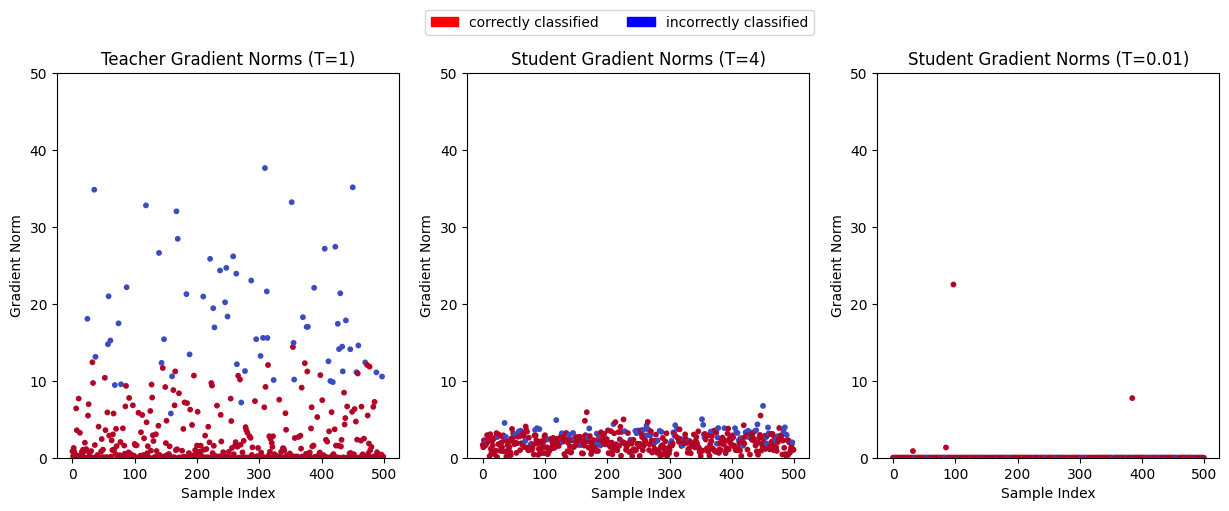

In [26]:
n = 500

softer_teacher_gradient_norms = get_gradient_norms(softer_teacher_model, x_test[:n], y_test_one_hot[:n])
softer_teacher_correct_predictions_mask = get_correct_predictions_mask(softer_teacher_model, x_test[:n], y_test_one_hot[:n])

softer_student_gradient_norms = get_gradient_norms(softer_student_model, x_test[:n], y_test_one_hot[:n])
softer_student_correct_predictions_mask = get_correct_predictions_mask(softer_student_model, x_test[:n], y_test_one_hot[:n])

softer_low_temp_student_gradient_norms = get_gradient_norms(softer_low_temp_student_model, x_test[:n], y_test_one_hot[:n])


# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Plot each scatter plot in its respective subplot
axes[0].scatter(range(n), softer_teacher_gradient_norms, c=softer_teacher_correct_predictions_mask, cmap="coolwarm", s=10)
axes[0].set_title("Teacher Gradient Norms (T=1)")
axes[0].set_xlabel("Sample Index")
axes[0].set_ylabel("Gradient Norm")
axes[0].set_ylim(0, 50)

axes[1].scatter(range(n), softer_student_gradient_norms, c=softer_student_correct_predictions_mask, cmap="coolwarm", s=10)
axes[1].set_title("Student Gradient Norms (T=4)")
axes[1].set_xlabel("Sample Index")
axes[1].set_ylabel("Gradient Norm")
axes[1].set_ylim(0, 50)

axes[2].scatter(range(n), softer_low_temp_student_gradient_norms, c=softer_student_correct_predictions_mask, cmap="coolwarm", s=10)
axes[2].set_title("Student Gradient Norms (T=0.01)")
axes[2].set_xlabel("Sample Index")
axes[2].set_ylabel("Gradient Norm")
axes[2].set_ylim(0, 50)

# Adjust layout for better spacing
red_correct = mpatches.Patch(color='red', label='correctly classified')
blue_incorrect = mpatches.Patch(color='blue', label='incorrectly classified')
fig.legend(
    handles=[red_correct, blue_incorrect],
    loc='upper center',  # Place the legend at the top-center
    bbox_to_anchor=(0.5, 1.02),  # Adjust the position
    ncol=2  # Spread the legend items across two columns
)

plt.show()

# Show the plots
plt.show()

Accuracy of 3 models on unperturbed sets

In [ ]:
n=1000
loss, accuracy = softer_teacher_model.evaluate(x_test[:n], y_test_one_hot[:n], verbose=0)
print(f"softer_teacher_model - loss: {loss}, accuracy: {accuracy}")

loss, accuracy = softer_low_temp_student_model.evaluate(x_test[:n], y_test_one_hot[:n], verbose=0)
print(f"softer_student_model - loss: {loss}, accuracy: {accuracy}")

loss, accuracy = softer_low_temp_student_model.evaluate(x_test[:n], y_test_one_hot[:n], verbose=0)
print(f"softer_low_temp_student_model - loss: {loss}, accuracy: {accuracy}")

softer_teacher_model - loss: 0.3881196081638336, accuracy: 0.8690000176429749
softer_student_model - loss: 0.5139288902282715, accuracy: 0.8209999799728394
softer_low_temp_student_model - loss: 0.5139288902282715, accuracy: 0.8209999799728394


Accuracy of models on perturbed sets

In [ ]:
n=1000
# fgsm on teacher
x_adv_test = AdversarialExamples.create_fgsm_dataset(softer_teacher_model, x_test[:n], y_test_one_hot[:n], eps=0.01)
loss, accuracy = softer_teacher_model.evaluate(x_adv_test, y_test_one_hot[:n], verbose=0)
print(f"softer_teacher_model - loss: {loss}, accuracy: {accuracy}")

# get fgsm from student t=50, apply to t=1
x_adv_test = AdversarialExamples.create_fgsm_dataset(softer_student_model, x_test[:n], y_test_one_hot[:n], eps=0.01)
loss, accuracy = softer_low_temp_student_model.evaluate(x_adv_test, y_test_one_hot[:n], verbose=0)
print(f"softer_low_temp_student_model (fgsm from softer_student_model) - loss: {loss}, accuracy: {accuracy}")

# get fgsm from student t=1 to student t=1
x_adv_test = AdversarialExamples.create_fgsm_dataset(softer_low_temp_student_model, x_test[:n], y_test_one_hot[:n], eps=0.01)
loss, accuracy = softer_low_temp_student_model.evaluate(x_adv_test, y_test_one_hot[:n], verbose=0)
print(f"softer_low_temp_student_model - loss: {loss}, accuracy: {accuracy}")

softer_teacher_model - loss: 2.6965014934539795, accuracy: 0.35100001096725464
softer_low_temp_student_model (fgsm from softer_student_model) - loss: 203.84959411621094, accuracy: 0.4480000138282776
softer_low_temp_student_model - loss: 45.45904541015625, accuracy: 0.8080000281333923


In [47]:
# n = 1000
# test_adversarial_dataset(softer_teacher_model, x_test, y_test, y_test_one_hot, 0.01, n, "softer_teacher_model")
# test_adversarial_dataset(softer_student_model, x_test, y_test, y_test_one_hot, 0.01, n, "softer_student_model")
# test_adversarial_dataset(softer_low_temp_student_model, x_test, y_test, y_test_one_hot, 0.01, n, "softer_low_temp_student_model")

In [9]:
adv_train_taught = AdversarialExamples.get_distillation_model(4)
adv_train_taught.load_weights("defensive_distillation/WithAdvTrainTeacher/second_distillation_model.weights.h5")

In [12]:
n=1000

loss, accuracy = adv_train_taught.evaluate(x_test[:n], y_test_one_hot[:n], verbose=0)
print(f"adv_train_taught - loss: {loss}, accuracy: {accuracy}")

# fgsm dataset
x_adv_test = AdversarialExamples.create_fgsm_dataset(adv_train_taught, x_test[:n], y_test_one_hot[:n], eps=0.01)
loss, accuracy = adv_train_taught.evaluate(x_adv_test, y_test_one_hot[:n], verbose=0)
print(f"adv_train_taught - loss: {loss}, accuracy: {accuracy}")

# fgsm + noise dataset
eps = 0.1
for i in range(0, n):
    x_adv_test[i] = x_adv_test[i] + eps * AdversarialExamples.create_random_pattern(x_test[0].shape)

loss, accuracy = adv_train_taught.evaluate(x_adv_test[:n], y_test_one_hot[:n], verbose=0)
print(f"fgsm + noise: {loss}, {accuracy}")

adv_train_taught - loss: 1.26175856590271, accuracy: 0.7860000133514404
adv_train_taught - loss: 4.554257869720459, accuracy: 0.4880000054836273
fgsm + noise: 2.9132442474365234, 0.5979999899864197


In [13]:
# adversarial training model + noise
x_adv_test = AdversarialExamples.create_fgsm_dataset(adv_training_model, x_test[:n], y_test_one_hot[:n], eps=0.01)
eps = 0.1
for i in range(0, n):
    x_adv_test[i] = x_adv_test[i] + eps * AdversarialExamples.create_random_pattern(x_test[0].shape)
loss, accuracy = adv_training_model.evaluate(x_adv_test, y_test_one_hot[:n], verbose=0)

print(f"adv_training_model - loss: {loss}, accuracy: {accuracy}")

adv_training_model - loss: 1.1302149295806885, accuracy: 0.6010000109672546


Miscellaneous

(32, 32, 3)
(32, 32, 3)


(-0.5, 31.5, 31.5, -0.5)

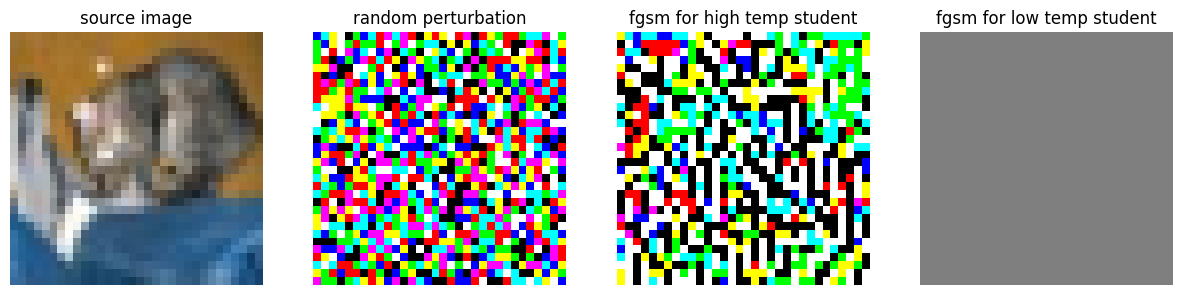

In [135]:
print(x_test[0].shape)
random_perturbation = AdversarialExamples.create_random_pattern(x_test[0].shape)
print(random_perturbation.shape)
high_temp_perturbation = AdversarialExamples.create_fgsm_pattern(student_model, x_test[0], y_test_one_hot[0])
low_temp_perturbation = AdversarialExamples.create_fgsm_pattern(low_temp_student_model, x_test[0], y_test_one_hot[0])

fig, axes = plt.subplots(1, 4, figsize=(15, 5))  # 1 row, 3 columns
axes[0].imshow(x_test[0])
axes[0].set_title("source image")
axes[0].axis('off')
axes[1].imshow(random_perturbation * 0.5 + 0.5)
axes[1].set_title("random perturbation")
axes[1].axis('off')
axes[2].imshow(high_temp_perturbation[0] * 0.5 + 0.5)
axes[2].set_title("fgsm for high temp student")
axes[2].axis('off')
axes[3].imshow(low_temp_perturbation[0] * 0.5 + 0.5)
axes[3].set_title("fgsm for low temp student")
axes[3].axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 31.5, 31.5, -0.5)

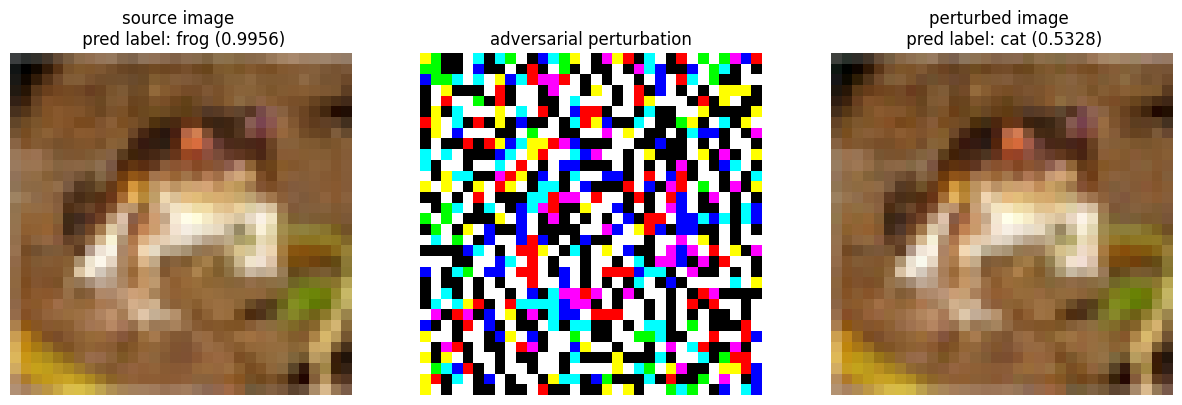

In [7]:
perturbation = AdversarialExamples.create_fgsm_pattern(original_model, x_train[0], y_train_one_hot[0])
perturbed_image = x_train[0] + 0.01 * perturbation

# original_model.evaluate(x_train, y_train_one_hot)

pred_1 = original_model(x_train[:1])
max_1 = tf.argmax(pred_1,axis=1)
class_1 = class_names[max_1[0]]
conf_1 = pred_1[0,max_1[0]]

pred_2 = original_model(perturbed_image)
max_2 = tf.argmax(pred_2,axis=1)
class_2 = class_names[max_2[0]]
conf_2 = pred_2[0,max_2[0]]


fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(x_train[0])
axes[0].set_title(f"source image \n pred label: {class_1} ({conf_1:.4f})")
axes[0].axis('off')
axes[1].imshow(perturbation[0] * 0.5 + 0.5)
axes[1].set_title("adversarial perturbation")
axes[1].axis('off')
axes[2].imshow(perturbed_image[0])
axes[2].set_title(f"perturbed image \n pred label: {class_2} ({conf_2:.4f})")
axes[2].axis('off')

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3913 - loss: 2.0347
loss: 2.159510850906372, accuracy: 0.3880000114440918


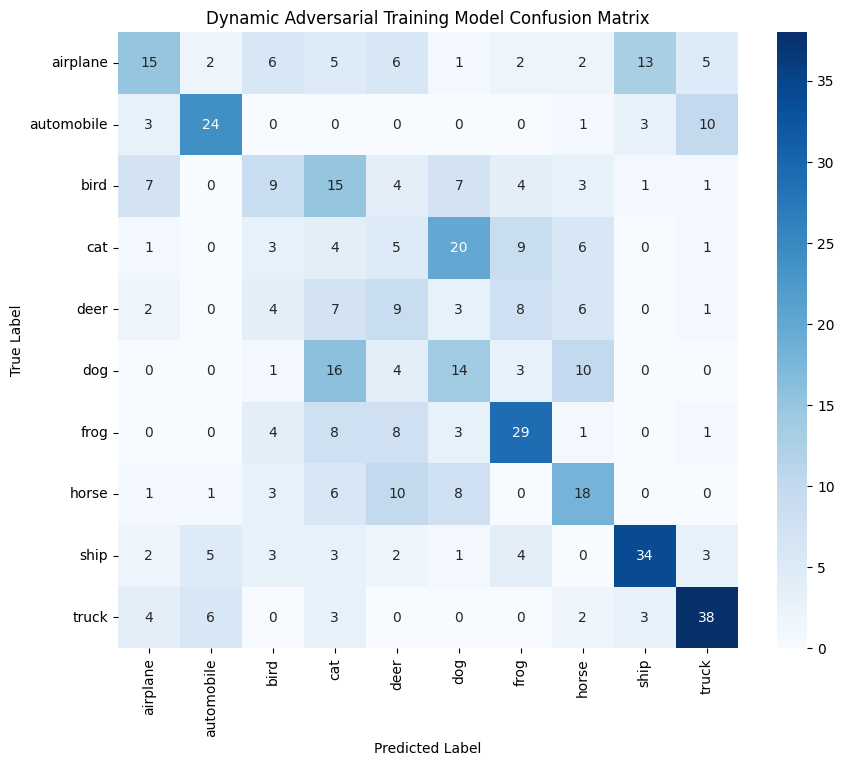

In [35]:
test_adversarial_dataset(dynamic_adv_training_model, x_test, y_test, y_test_one_hot, 0.01, 500, "Dynamic Adversarial Training Model")

In [46]:
print(student_model(x_test[:1]))
print(low_temp_student_model(x_test[:1]))

tf.Tensor(
[[2.6787049e-03 1.2009221e-03 1.7382522e-03 9.0506876e-01 1.2278122e-04
  1.5440716e-02 3.2566682e-02 2.7946420e-05 4.0079053e-02 1.0761232e-03]], shape=(1, 10), dtype=float32)
tf.Tensor([[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]], shape=(1, 10), dtype=float32)


In [48]:
print(teacher_model(x_train[:5]))

tf.Tensor(
[[1.55983688e-08 7.57720500e-07 8.33925500e-04 5.00244182e-03
  1.35941154e-04 4.71865438e-04 9.93543148e-01 1.04954615e-05
  1.26173427e-06 5.30150608e-08]
 [1.93945243e-06 2.17216578e-03 5.85683154e-07 1.26250984e-06
  1.38623202e-08 9.32019120e-08 1.69877090e-08 7.59112368e-07
  1.98923135e-05 9.97803152e-01]
 [3.42111140e-02 2.17311527e-03 7.00328383e-05 2.27777782e-04
  5.33357728e-04 1.63694967e-05 1.19065815e-04 5.78585677e-05
  1.25422366e-02 9.50049043e-01]
 [1.53162759e-07 6.18330542e-09 1.13043661e-05 3.86729835e-06
  9.99857068e-01 1.17598611e-05 1.07862943e-04 7.98584097e-06
  9.37946609e-09 6.43115339e-09]
 [1.19914549e-13 1.00000000e+00 7.92560311e-16 1.62124637e-17
  3.98186590e-18 9.14230122e-18 2.96734911e-16 1.22627648e-17
  1.59377297e-12 4.89644436e-10]], shape=(5, 10), dtype=float32)


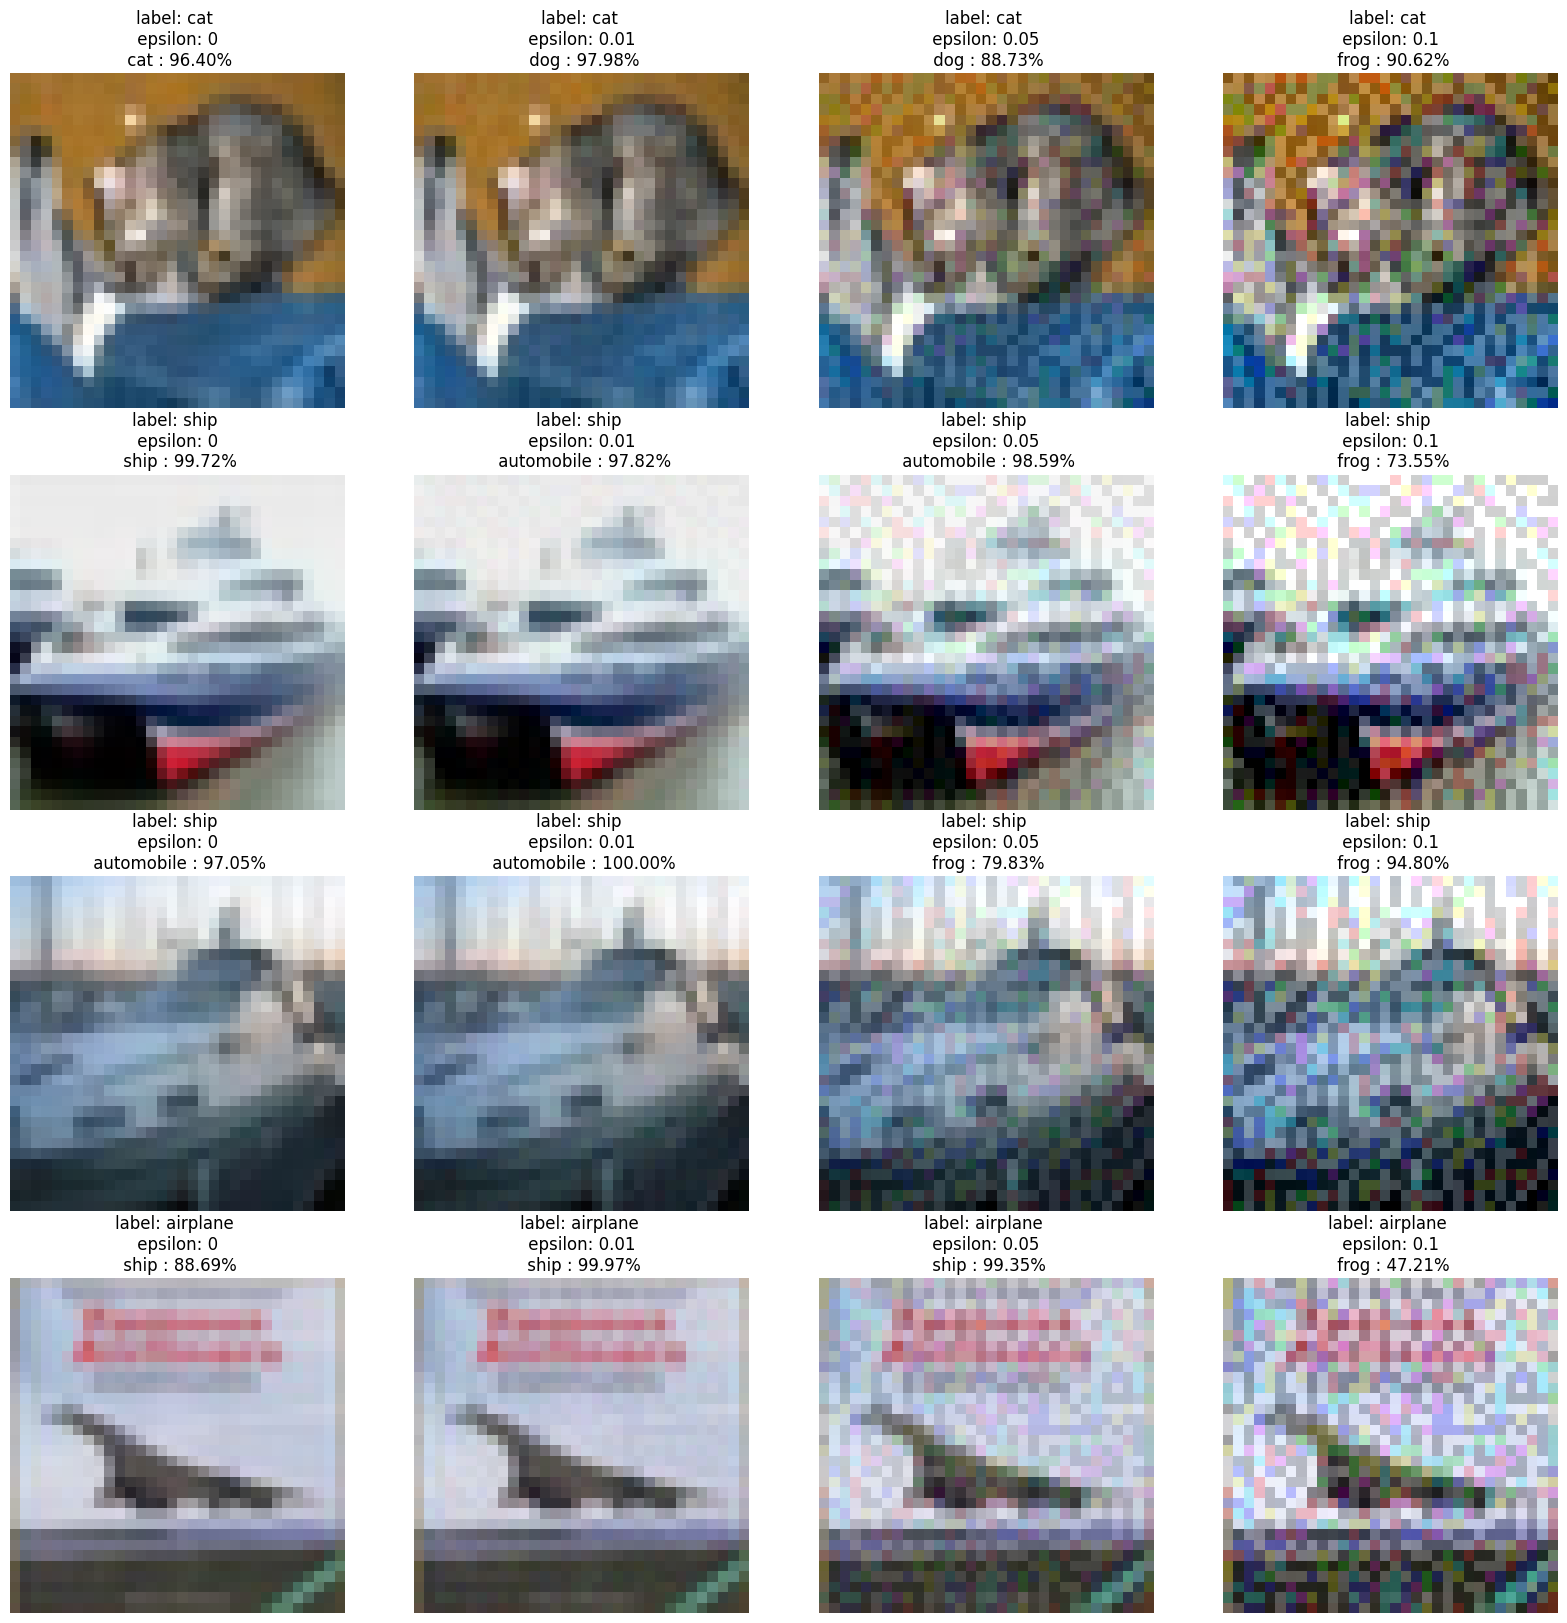

In [5]:
# class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
epsilons = [0, 0.01, 0.05, 0.1]

fig = plt.figure(figsize=(20,20))
for j in range(4):
    for i in range(len(epsilons)):
        fig.add_subplot(4, 4, i+1 +j*4)

        x_adv = x_test[j] + epsilons[i] * AdversarialExamples.create_fgsm_pattern(original_model, x_test[j], y_test_one_hot[j])
        x_adv = tf.clip_by_value(x_adv, 0, 1)

        prediction = original_model(x_adv)
        image_class = class_names[np.argmax(prediction)]
        conf = np.max(prediction)
        
        plt.imshow(x_adv[0])
        plt.axis('off')
        plt.title('label: {} \n epsilon: {} \n {} : {:.2f}%'.format(class_names[y_test[j][0]], epsilons[i], image_class, conf * 100))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0628 - loss: 6.9057
loss: 7.034529685974121, accuracy: 0.05400000140070915


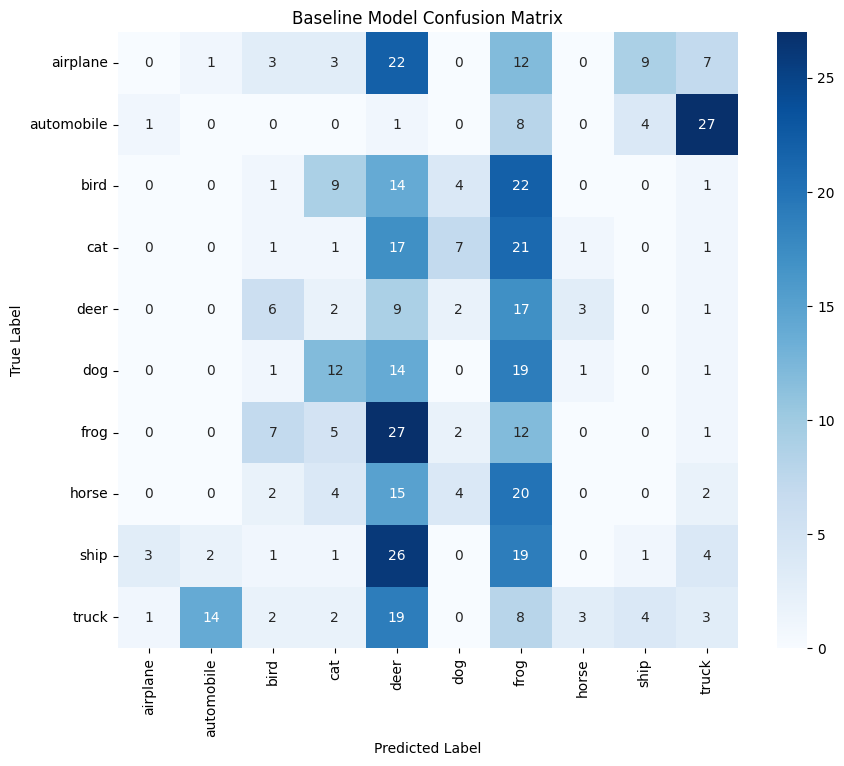

In [9]:
test_adversarial_dataset(original_model, x_test, y_test, y_test_one_hot, 0.05, 500, "Baseline Model")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0381 - loss: 6.7562
loss: 6.780327796936035, accuracy: 0.035999998450279236


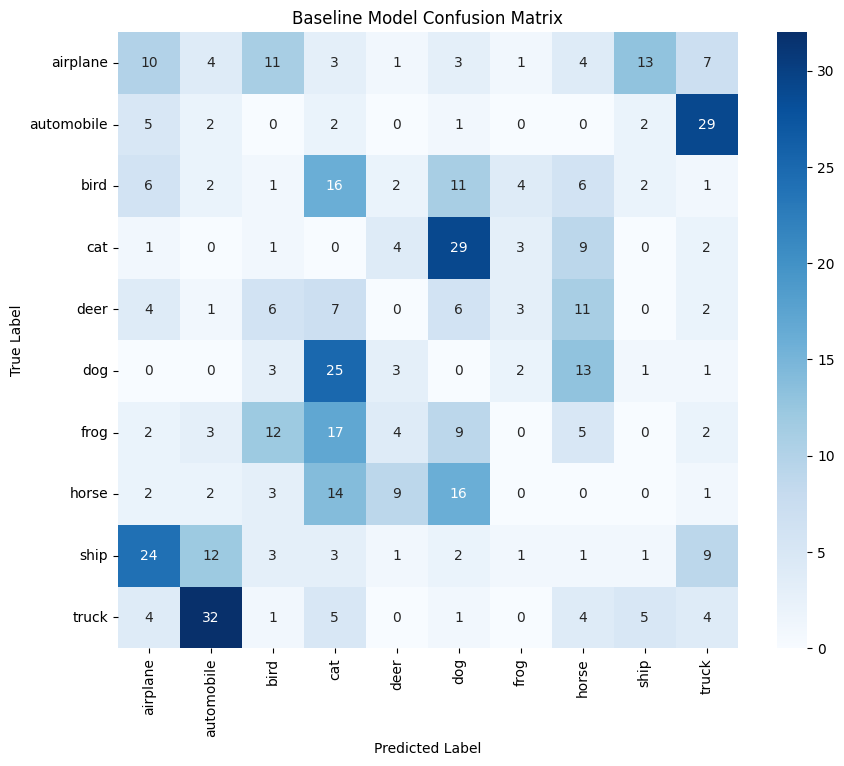

In [10]:
test_adversarial_dataset(adv_training_model, x_test, y_test, y_test_one_hot, 0.05, 500, "Baseline Model")

In [4]:
eps = 0.01
x_random_adv_test = np.empty(x_test.shape)
for i in range(0, len(x_test)):
    x_random_adv_test[i] = x_test[i] + eps * AdversarialExamples.create_random_pattern(x_test[0].shape)
    x_random_adv_test[i] = tf.clip_by_value(x_random_adv_test[i], 0, 1)
    

loss, accuracy = original_model.evaluate(x_random_adv_test, y_test_one_hot, verbose=1)
print(loss, accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8302 - loss: 0.5088
0.5052476525306702 0.8302000164985657
